In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [119]:
import pandas as pd
import json
import numpy as np
import pickle
from modules.functions import pymatgen_comp,data_generator_vec, get_comp
from modules.mongodb_rom import calculate_density, calculate_price
from modules.trained_models import get_uts_without_grain
import matplotlib.pyplot as plt
from pymoo.problems.functional import FunctionalProblem
import pymatgen.core as mg

In [120]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/starting_comp.json','r') as fid:
    json_dict = json.load(fid)

## Multi-objective optimization

In [126]:
def decode(vec, elem_list, thresh=0.03):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    comp = ''
    for i, x in enumerate(vec):
        if x >= thresh:
            comp += elem_list[i] + '{:.2f} '.format(x)
    return mg.Composition(comp)


def wrapper_uts(val_array):
    return get_uts_without_grain(np.array(val_array).reshape(1,-1)).item()

def wrapper_w(val_array, element_list = el_list):
    w_ind = np.argwhere(np.array(element_list)=='W').item()
    return val_array[w_ind]

def wrapper_price(val_array, element_list = el_list):
    comp = get_comp(np.array(val_array),element_list)
    return calculate_price(comp)

def wrapper_density(val_array, element_list = el_list):
    comp = get_comp(np.array(val_array),element_list)
    return calculate_density(comp)
      

In [130]:
lb = np.zeros_like(json_dict['start_comp'])
ub = np.zeros_like(json_dict['start_comp'])
for i,k in enumerate(lb):
    if el_list[i] == 'W':
        lb[i] = 0
    else:
        lb[i] = 0.0
for i,k in enumerate(lb):
    if el_list[i] in ['Nb','Mo','Zr','Ti','V','W','Hf','Cr','Ta']:
        ub[i] = 1
    else:
        ub[i] = 0
    
ub,lb

(array([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]))

In [330]:
objs = [
    
    #lambda x: wrapper_w(x),
    lambda x: -wrapper_uts(x),
    lambda x : wrapper_price(x)
    
]

constr_eq = [
    lambda x: 1 - np.sum((x))
]

constr_ineq = [
    lambda x : 8 - wrapper_density(x),
    lambda x : wrapper_density(x)-10
]


n_var = len(el_list)

problem = FunctionalProblem(n_var,
                            objs,
                            constr_eq = constr_eq,
                            constr_ieq= constr_ineq,
                            xu=ub,
                            xl=lb
                            )

In [331]:
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.lhs import LHS
from pymoo.constraints.as_obj import ConstraintsAsObjective



ref_points = np.array([-1,30]).reshape(1,-1)

algorithm = RNSGA2(
    ref_points=ref_points,
    pop_size=500,
    n_offsprings=50,
    sampling=LHS(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
    epsilon=0.01,
    normalization='front',
    extreme_points_as_reference_points=False,
    weights=np.array([0.5,0.5])
)


from pymoo.termination import get_termination

termination = get_termination( "n_gen",200)

In [332]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed= 1,
               save_history=True,
               verbose=True)
X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      500 |      1 |  1.5030037322 |  3.9794943432 |             - |             -
     2 |      550 |      1 |  1.5030037322 |  3.7567149765 |             - |             -
     3 |      600 |      1 |  1.5030037322 |  3.6077086867 |             - |             -
     4 |      650 |      1 |  0.9417230197 |  3.4592849556 |             - |             -
     5 |      700 |      1 |  0.8653394502 |  3.3041500080 |             - |             -
     6 |      750 |      1 |  0.8653394502 |  3.1763928674 |             - |             -
     7 |      800 |      1 |  0.8653394502 |  3.0491473047 |             - |             -
     8 |      850 |      1 |  0.8653394502 |  2.9277010943 |             - |             -
     9 |      900 |      1 |  0.8653394502 |  2.7986508844 |             - |             -
    10 |      950 |      1 |  0.8317471463 |  2.6815067660 |             - |             -

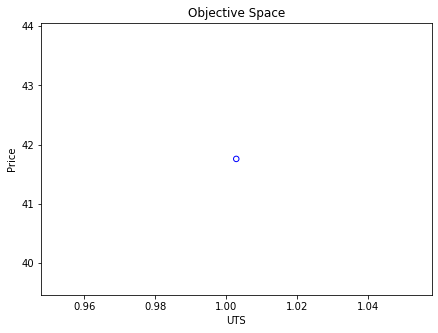

In [333]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(-1*F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
#plt.scatter(wrapper_ft(at_frac), wrapper_uts(json_dict['start_comp']), s=30, facecolors='none', edgecolors='red')
plt.title("Objective Space")
plt.xlabel('UTS')
plt.ylabel('Price')
plt.show()

In [334]:
get_comp(X.flatten(), el_list), wrapper_uts(X), wrapper_density(X.flatten()), wrapper_price(X.flatten())

(Comp: Zr0.03 Ti0.14 Nb0.2 Cr0.11 Mo0.52,
 1.0028961896896362,
 8.529357756032299,
 41.757)

In [ ]:
optimized =[]
for f in X:
    optimized.append(decode(f, elem_list=el_list))
optimized

[Comp: Hf0.07 Zr0.12 Ti0.37 V0.03 Cr0.09 Mo0.13 W0.18,
 Comp: Hf0.2 Zr0.12 Ti0.37 V0.03 Cr0.05 Mo0.04 W0.18,
 Comp: Hf0.2 Zr0.12 Ti0.37 V0.03 Cr0.05 Mo0.04 W0.18]

In [ ]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data

In [ ]:
w_ind = np.argwhere(np.array(el_list) == 'W').item() 
w_content = vec_comps[:,w_ind]
uts = to_train_df['uts1200C'].values


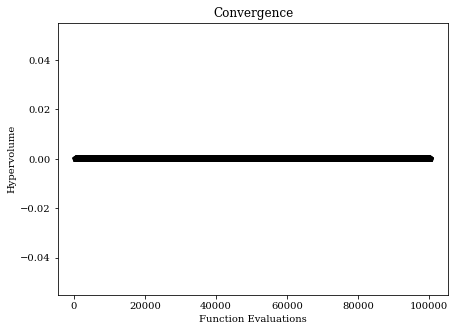

In [27]:
hist = res.history
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])


approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= ref_points.flatten(),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

## Pareto optimal solutions

In [4]:
with open('misc/starting_comp.json','r') as fid:
    start_comp_dict = json.load(fid)

start_comp = start_comp_dict['start_comp']
start_comp_decoded = get_comp(np.array(start_comp), el_list)
#pmg_start_comp = pymatgen_comp([start_comp_decoded])[0]

start_price = calculate_price(start_comp_decoded)
start_density = calculate_density(start_comp_decoded)

start_price, start_density


(187.546, 12.5188005018155)

In [5]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data


w_ind = np.argwhere(np.array(el_list) == 'W').item() 
w_content = vec_comps[:,w_ind]
uts = to_train_df['uts1200C'].values
density = to_train_df['density'].values
price = to_train_df['price'].values

dist = np.array([np.linalg.norm(x - start_comp) for x in vec_comps]).reshape(-1,1)




def is_pareto_efficient(costs, return_mask = True):
    """    Find the pareto-efficient points    :param costs: An (n_points, n_costs) array    :param return_mask: True to return a mask    :return: An array of indices of pareto-efficient points.        If return_mask is True, this will be an (n_points, ) boolean array        Otherwise it will be a (n_efficient_points, ) integer array of indices.    """    
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for    
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True        
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points        
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1    
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True        
        return is_efficient_mask    
    else:
        return is_efficient

In [309]:
range_w = (vec_comps[:,-1]>=0.0)

def get_number_of_components(comp_list):
  count_list = []
  for c in comp_list:
    if not type(c) == mg.Composition:
      c = mg.Composition(c)
      count_list.append(len(list(c.get_el_amt_dict().keys())))
  return count_list


c = np.array(get_number_of_components(to_train_df['Composition'])).reshape(-1,1)[range_w]
w_content_filt = w_content[range_w]
uts_filt = uts[range_w]
dist_filt = dist[range_w]
density_filt = density[range_w]
price_filt = price[range_w]



costs = np.hstack((-uts_filt.reshape(-1,1), density_filt.reshape(-1,1)-9, price_filt.reshape(-1,1), 4-c))

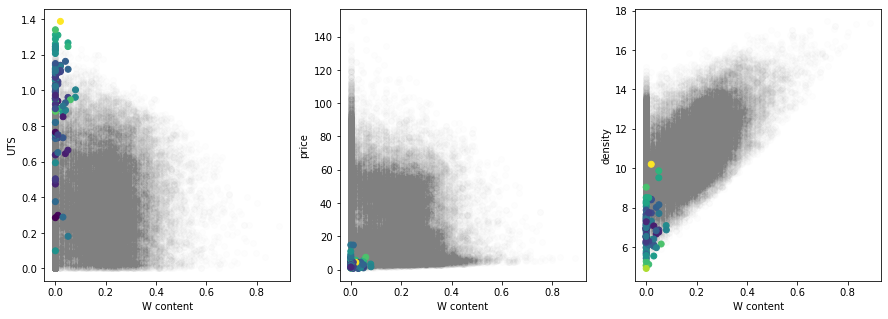

In [310]:
pareto_eff = is_pareto_efficient(costs)
non_pareto = ~pareto_eff

fig, ax = plt.subplots(1,3, figsize = (15,5))
ax = ax.ravel()

list_of_prop = ['UTS','price','density']
for i,n in enumerate((list_of_prop)):
    if n == 'UTS':
        ax[i].scatter(w_content_filt[non_pareto],uts_filt[non_pareto],c = 'grey', alpha = 0.01)
        ax[i].scatter(w_content_filt[pareto_eff],uts_filt[pareto_eff],c = dist_filt[pareto_eff])   
    elif n == 'price':
        ax[i].scatter(w_content_filt[non_pareto],price_filt[non_pareto],c = 'grey', alpha = 0.01)
        ax[i].scatter(w_content_filt[pareto_eff],price_filt[pareto_eff],c = dist_filt[pareto_eff])  
    if n == 'density':
        ax[i].scatter(w_content_filt[non_pareto],density_filt[non_pareto],c = 'grey', alpha = 0.01)
        ax[i].scatter(w_content_filt[pareto_eff],density_filt[pareto_eff],c = dist_filt[pareto_eff])     
    ax[i].set_xlabel('W content')
    ax[i].set_ylabel(n)
        #ax[i].colorbar()

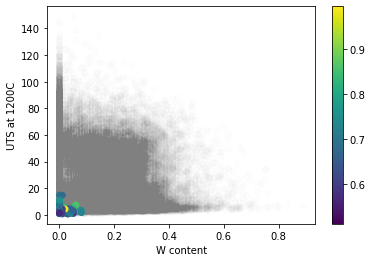

In [311]:
plt.scatter(w_content_filt[non_pareto],price_filt[non_pareto],c = 'grey', alpha = 0.01)
plt.scatter(w_content_filt[pareto_eff],price_filt[pareto_eff],c = dist_filt[pareto_eff])
plt.xlabel('W content')
plt.ylabel('UTS at 1200C')
plt.colorbar()

In [323]:
from pymoo.indicators.hv import HV

ref_point = np.array([-1, 1, 30,0])
ind = HV(ref_point=ref_point)


costs = np.hstack((-uts_filt.reshape(-1,1), density_filt.reshape(-1,1)-9, price_filt.reshape(-1,1),4-c))


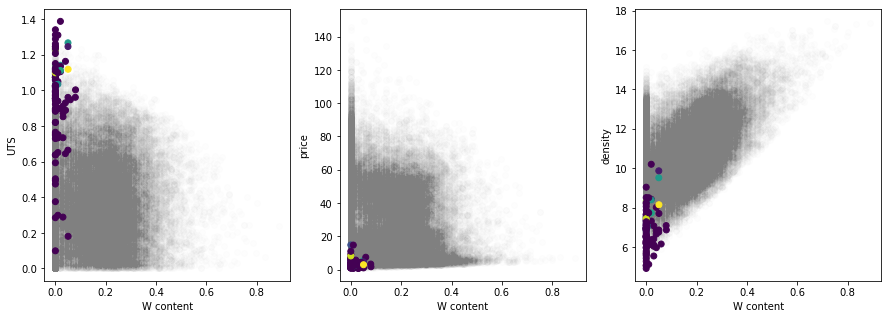

In [324]:
hvs = np.array([ind(x) for x in costs])

fig, ax = plt.subplots(1,3, figsize = (15,5))
ax = ax.ravel()

list_of_prop = ['UTS','price','density']
for i,n in enumerate((list_of_prop)):
    if n == 'UTS':
        ax[i].scatter(w_content_filt[non_pareto],uts_filt[non_pareto],c = 'grey', alpha = 0.01)
        ax[i].scatter(w_content_filt[pareto_eff],uts_filt[pareto_eff],c = hvs[pareto_eff])   
    elif n == 'price':
        ax[i].scatter(w_content_filt[non_pareto],price_filt[non_pareto],c = 'grey', alpha = 0.01)
        ax[i].scatter(w_content_filt[pareto_eff],price_filt[pareto_eff],c = hvs[pareto_eff])  
    if n == 'density':
        ax[i].scatter(w_content_filt[non_pareto],density_filt[non_pareto],c = 'grey', alpha = 0.01)
        ax[i].scatter(w_content_filt[pareto_eff],density_filt[pareto_eff],c = hvs[pareto_eff])     
    ax[i].set_xlabel('W content')
    ax[i].set_ylabel(n)
        #ax[i].colorbar()

In [335]:
test = vec_comps[range_w][np.argmax(hvs)]
test_comp = get_comp(test, el_list)
get_uts_without_grain(test.reshape(1,-1)), calculate_density(test_comp), calculate_price(test_comp)

(array([[1.1237935]], dtype=float32), 8.245214487087075, 31.537000000000003)

In [336]:
calculate_entropy_mixing(test_comp)

-1.119216895692202

In [337]:
test_comp

Comp: Zr0.03 Ti0.37 Nb0.05 Mo0.5 W0.05

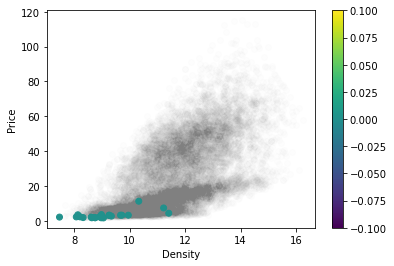

In [11]:
hvs = np.array([ind(x) for x in costs])
plt.scatter(density_filt[non_pareto],price_filt[non_pareto],c= 'grey', alpha = 0.01)
plt.scatter(density_filt[pareto_eff],price_filt[pareto_eff],c= hvs[pareto_eff])

#plt.scatter(start_comp_dict['start_w_content'], start_comp_dict['start_uts'], marker = '*', c = 'yellow' )
plt.xlabel('Density')
plt.ylabel('Price')
plt.colorbar()

In [12]:
ranges = np.arange(np.max(w_content_filt),np.round(np.min(w_content_filt),2),-0.01)
w_list, uts_list, hv_list, comps_hts = [], [], [], []
for r in ranges:
    t = (w_content_filt[pareto_eff] <= r) * (w_content_filt[pareto_eff] >= r - 0.009)
    try:
        max_hv = np.argmax(hvs[pareto_eff][t])
        w_list.append(w_content_filt[pareto_eff][t][max_hv])
        uts_list.append(uts_filt[pareto_eff][t][max_hv])
        hv_list.append(hvs[pareto_eff][t][max_hv])
        comps_hts.append(vec_comps[range_w][pareto_eff][t][max_hv])

    except:
        pass
    


Text(0, 0.5, 'UTS at 1200C')

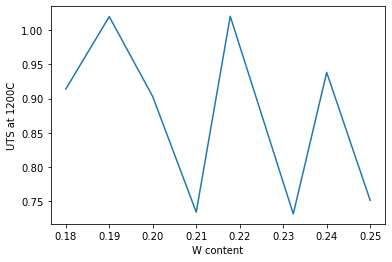

In [13]:
plt.plot(w_list,uts_list)
plt.xlabel('W content')
plt.ylabel('UTS at 1200C')

In [23]:
t = get_comp(vec_comps[range_w][pareto_eff][t][max_hv], el_list)
t, calculate_density(t), calculate_price(t)

(Comp: Ti0.44 Cr0.21 Mo0.16 W0.18, 8.656331462252307, 20.092929292929295)

In [125]:
hts_dict = {
    'w_content_hts':w_list,
    'uts_hts':uts_list,
    'final_comp':vec_comps[range_w][pareto_eff][t][max_hv].tolist(),
    'all_comps':comps_hts
}

with open('misc/hts_result_multi.pkl','wb') as fid:
    pickle.dump(hts_dict,fid)